In [118]:
import numpy as np
import pandas as pd
from scipy import stats

from scipy.stats import norm
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms



In [3]:
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') ## High Res

index = osc.get_index(dfres.odor,4)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign

In [4]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)


Optimal Parameters:
A = 0.015440812476984683
x0 = 0.0
y0 = 0.0
sigma_x = 21.706226196705753
sigma_y = 0.460846558485007
theta = 3.122688198110767


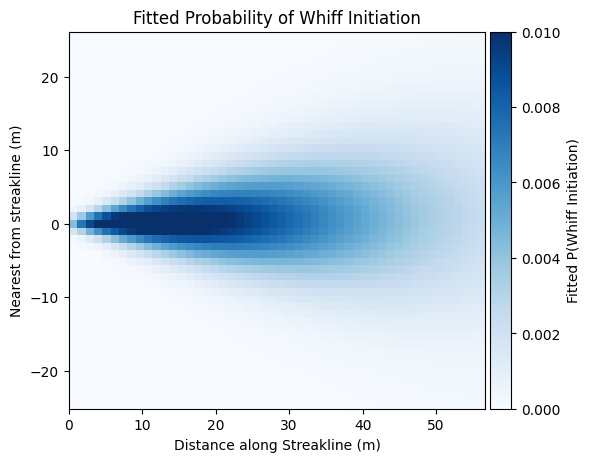

In [5]:
def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y, damping_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)

    sigma_x = base_sigma_x + distance_scale_factor_x * np.sqrt(distance_from_source)
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source 
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)

    p = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2))) * np.exp(-damping_factor / (distance_from_source + 1))
    
    return p


x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
initial_params = [1.0, 0.0, 0.0, 30, 3, 0.0, 0.6, 0.3, 0.8] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,1),
    (0,1),
    (0.5,2)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape((len(x_centers), len(y_centers)))

# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0,vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')

f.tight_layout()

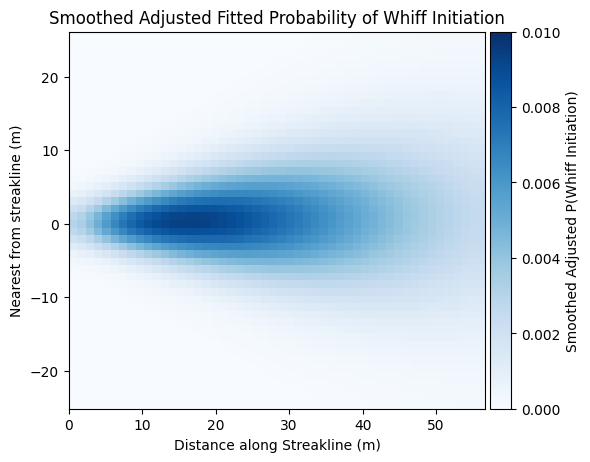

In [6]:
def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2.0  # Gaussian smoothing standard deviation

# Smoothly adjust the fitted probability heatmap
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(fitted_p_heatmap, region_mask, adjustment_factor, sigma=sigma_smoothing)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Smoothed Adjusted Fitted Probability of Whiff Initiation')

f.tight_layout()



In [9]:
# fitted_p_heatmap_1=smoothed_fitted_p_heatmap

In [7]:

class OdorPredictor:
    def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
        self.fitted_p_heatmap = fitted_p_heatmap
        self.xedges = xedges
        self.yedges = yedges
        self.distance_threshold = distance_threshold
        self.rows_per_second = rows_per_second
        self.base_odor_level = base_odor_level
        self.initialize_data(fdf, fdf_nowhiff)

    def initialize_data(self, fdf, fdf_nowhiff):
        # Extract necessary data as arrays for faster access
        self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.whiff_means = fdf.mean_concentration.values
        self.whiff_stds = fdf.std_whiff.values
        self.whiff_duration = fdf.length_of_encounter.values
        self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
        self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

    def predict_whiff_from_probability(self, x, y):
        x_bin = np.digitize(x, self.xedges) - 1
        y_bin = np.digitize(y, self.yedges) - 1
        if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
            return False, 0
        whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
        return np.random.rand() < whiff_prob, whiff_prob

    @staticmethod
    def moving_average(data, window_size=5):
        # Adjust moving average to keep the same length as input data
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

    def predict_odor_concentration(self, x, y):
        # Convert DataFrame columns to NumPy arrays
        df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
        odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
        whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

        test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
        distances = cdist(test_locations, self.whiff_locations)
        distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

        # Process whiff and no-whiff regions
        odor_concentration_samples, whiff_prediction_samples = self.process_whiff_regions(
            distances, odor_concentration_samples, whiff_prediction_samples, test_locations
        )
        odor_concentration_samples = self.process_no_whiff_regions(
            distances_nowhiff, odor_concentration_samples
        )

        # Return results as DataFrame
        df_test['predicted_odor'] = odor_concentration_samples
        df_test['whiff_predicted'] = whiff_prediction_samples
        return df_test

    def process_whiff_regions(self, distances, odor_concentration_samples, whiff_prediction_samples, test_locations):
        for i, (dist_along, nearest_from) in enumerate(test_locations):
            whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
            if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
                nearest_whiff_idx = np.argmin(distances[i])
                mean_concentration = self.whiff_means[nearest_whiff_idx]
                std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
                duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
                rows_to_fill = min(duration, len(odor_concentration_samples) - i)

                generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
                generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
                odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
                whiff_prediction_samples[i:i + rows_to_fill] = 1
        return odor_concentration_samples, whiff_prediction_samples

    def process_no_whiff_regions(self, distances_nowhiff, odor_concentration_samples):
        i = 0
        while i < len(odor_concentration_samples):
            if odor_concentration_samples[i] == self.base_odor_level:
                nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
                no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

                start = i
                while i < len(odor_concentration_samples) and odor_concentration_samples[i] == self.base_odor_level:
                    i += 1
                end = i

                no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
                no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
                
                # Check if moving average should be applied
                if end - start >= 5:  # Apply only if length >= window size
                    smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)
                    odor_concentration_samples[start:end] = smoothed_concentrations[:end - start]
                else:
                    odor_concentration_samples[start:end] = no_whiff_concentrations
            else:
                i += 1
        return odor_concentration_samples

if __name__ == "__main__":

    dirname = '../data/simulator/hws/'
    hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
    predictor = OdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=pd.read_hdf(str(dirname) + 'whiff.h5'),
        fdf_nowhiff=pd.read_hdf(str(dirname) + 'nowhiff.h5')
    )
    
    df = pd.read_hdf(str(dirname) + 'hwsDesert.h5')
    df_test = df[10000:].reset_index(drop=True)
    x = df_test.distance_along_streakline.values
    y = df_test.nearest_from_streakline.values

    pdf = predictor.predict_odor_concentration(x, y)


In [9]:
df_test['predicted_odor']=pdf.predicted_odor
df_test['whiff_predicted']=pdf.whiff_predicted

In [14]:
index = osc.get_index(df_test.predicted_odor,4)
whiff_initiation_points = [sub[0] for sub in index]
df_test['whiff_flag_predicted'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
df_test.iloc[whiff_initiation_points, df_test.columns.get_loc('whiff_flag_predicted')] = 1

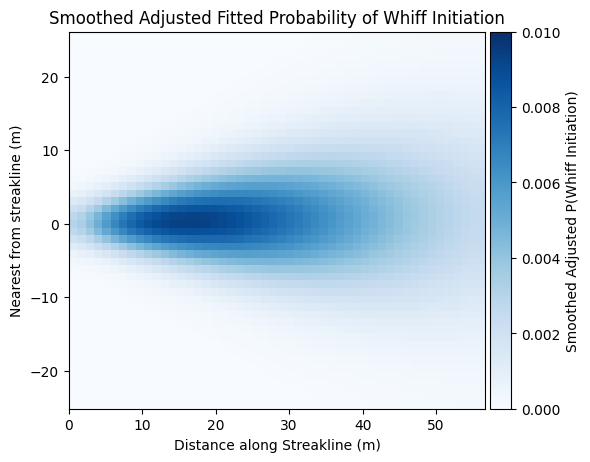

In [102]:
# Correctly load each individual element
fitted_p_heatmap = hmap_data['fitted_p_heatmap']
xedges = hmap_data['xedges']
yedges = hmap_data['yedges']

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Smoothed Adjusted Fitted Probability of Whiff Initiation')

f.tight_layout()
plt.show()


Text(0.5, 1.0, 'Probability of Whiff Initiation - Predicted Odor')

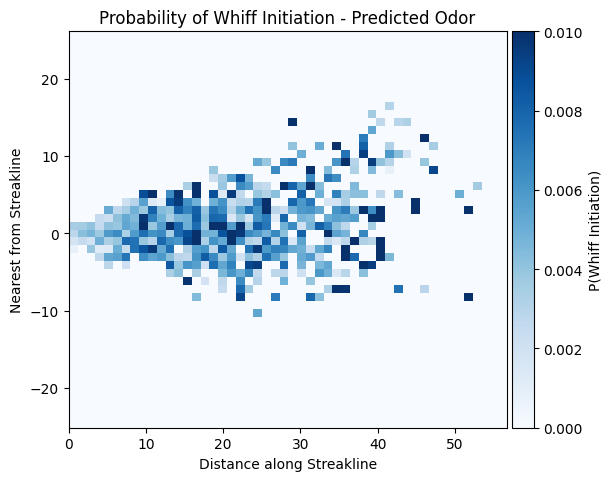

In [106]:
n_bins_x = n_bins_y = 50  # Define your bin size
predicted_whiff_counts, xedges, yedges = np.histogram2d(
    pdf['distance_along_streakline'],
    pdf['nearest_from_streakline'],
    bins=[n_bins_x, n_bins_y],
    weights=df_test['whiff_flag_predicted']
)

predicted_total_counts, _, _ = np.histogram2d(
    df_test['distance_along_streakline'],
    df_test['nearest_from_streakline'],
    bins=[n_bins_x, n_bins_y]
)

with np.errstate(divide='ignore', invalid='ignore'):
    predicted_prob_heatmap = np.divide(
        predicted_whiff_counts, predicted_total_counts, out=np.zeros_like(predicted_whiff_counts), where=predicted_total_counts != 0
    )


f, ax = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax.imshow(predicted_prob_heatmap.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues', vmin=0, vmax=0.01)
divider1 = make_axes_locatable(ax)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax.set_ylabel('Nearest from Streakline')
ax.set_xlabel('Distance along Streakline')
ax.set_title('Probability of Whiff Initiation - Predicted Odor')

Text(0.5, 1.0, 'Probability of Whiff Initiation - Actual Odor')

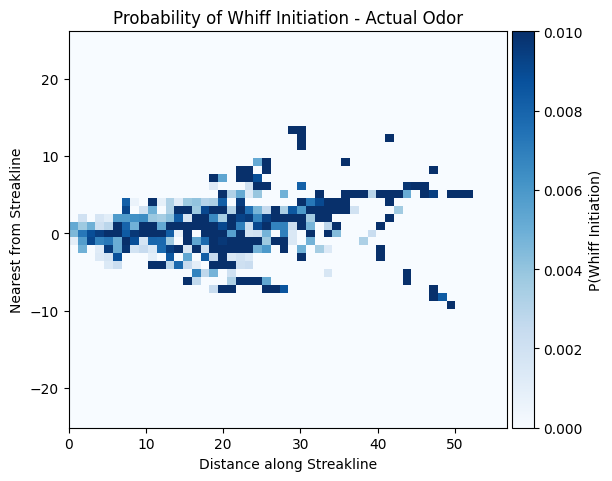

In [105]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)


f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues', vmin=0, vmax=0.01)
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_xlabel('Distance along Streakline')
ax1.set_title('Probability of Whiff Initiation - Actual Odor')


/tmp/ipykernel_76266/1775554726.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


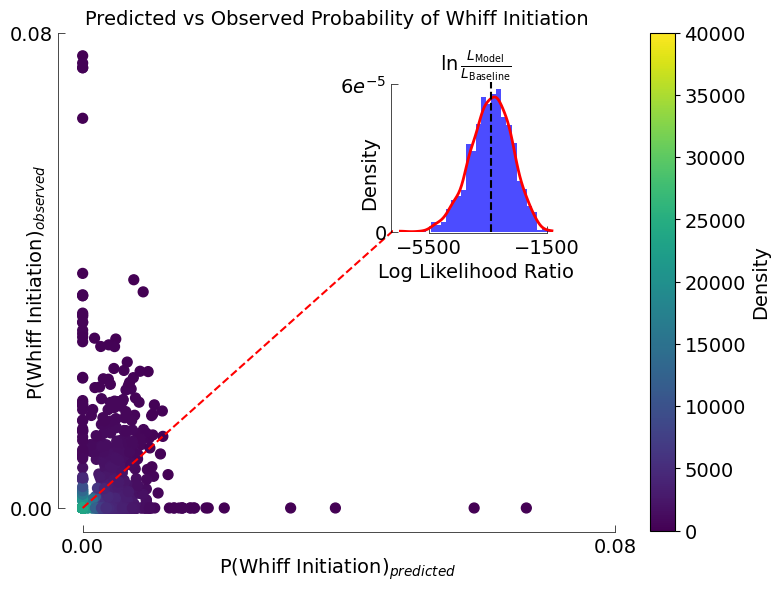

In [162]:

# Define your observed and predicted probabilities
observed_probs = heatmap_prob.flatten()  # Observed probability from actual data
predicted_probs = predicted_prob_heatmap.flatten()  # Predicted probability from model

# Filter out bins with zero total observations to avoid issues with log(0)
valid_bins = heatmap_total.flatten() > 0
observed_probs = observed_probs[valid_bins]
predicted_probs = predicted_probs[valid_bins]
observed_whiff_counts = heatmap_whiff.flatten()[valid_bins]  # Number of observed whiffs per bin
total_counts = heatmap_total.flatten()[valid_bins]  # Total samples per bin

# Step 1: Define the log likelihood function
def calculate_log_likelihood(observed_counts, total_counts, predicted_probs):
    epsilon = 1e-10  # Small constant to avoid log(0)
    predicted_probs = np.clip(predicted_probs, epsilon, 1 - epsilon)
    ll = observed_counts * np.log(predicted_probs) + (total_counts - observed_counts) * np.log(1 - predicted_probs)
    return np.sum(ll)

# Step 2: Baseline Model (e.g., uniform random probability)
# Define a baseline probability (e.g., 0.5, or the mean of the observed probabilities)
baseline_prob = np.mean(observed_probs)
baseline_probs = np.full_like(predicted_probs, baseline_prob)

# Step 3: Bootstrapping for log likelihood ratio
def bootstrap_log_likelihood(observed_counts, total_counts, predicted_probs, baseline_probs, n_bootstraps=1000):
    ll_ratios = []
    for _ in range(n_bootstraps):
        # Resample observed counts with replacement
        resampled_indices = np.random.choice(len(observed_counts), size=len(observed_counts), replace=True)
        resampled_counts = observed_counts[resampled_indices]
        resampled_totals = total_counts[resampled_indices]
        
        # Calculate log likelihood for model predictions and baseline
        ll_pred = calculate_log_likelihood(resampled_counts, resampled_totals, predicted_probs[resampled_indices])
        ll_baseline = calculate_log_likelihood(resampled_counts, resampled_totals, baseline_probs[resampled_indices])
        
        # Log likelihood ratio
        ll_ratio = ll_pred - ll_baseline
        ll_ratios.append(ll_ratio)
    
    return np.array(ll_ratios)

# Run bootstrapping
n_bootstraps = 1000
ll_ratios = bootstrap_log_likelihood(observed_whiff_counts, total_counts, predicted_probs, baseline_probs, n_bootstraps)

# # Step 4: Plot Distribution of Log Likelihood Ratios
# plt.figure(figsize=(8, 6))
# plt.hist(ll_ratios, bins=30, color='blue', alpha=0.7)
# plt.axvline(np.mean(ll_ratios), color='red', linestyle='--', label='Mean Log Likelihood Ratio')
# plt.xlabel('Log Likelihood Ratio (Model - Baseline)')
# plt.ylabel('Frequency')
# plt.title('Distribution of Log Likelihood Ratios (Model vs Baseline)')
# plt.legend()
# plt.show()

# Step 1: Create the main figure and axis
f, ax = plt.subplots(figsize=(8, 6))

# Main density scatter plot (as in your previous example)
xy = np.vstack([predicted_probs, observed_probs])
kde = gaussian_kde(xy)(xy)
scatter = ax.scatter(predicted_probs, observed_probs, c=kde, s=50, cmap='viridis',vmin=0,vmax=40000)
ax.plot([0, 0.07], [0, 0.07], 'r--')  # 45-degree line for perfect prediction
cbar = f.colorbar(scatter, ax=ax, label='Density')
ax.set_xlabel('P(Whiff Initiation)$_{predicted}$')
ax.set_ylabel('P(Whiff Initiation)$_{observed}$')
ax.set_title('Predicted vs Observed Probability of Whiff Initiation')

mpl_functions.adjust_spines(ax,['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,0.08],
                        yticks=[0,0.08],
                        linewidth=0.5)

ax.yaxis.set_label_coords(-0.02, 0.5)
ax.xaxis.set_label_coords(0.5, -0.05)

# Define the position in axis coordinates (e.g., x=0.6, y=0.6 with width and height in axis-relative terms)
bbox = mtransforms.Bbox.from_bounds(-0.1, -0.1, 1, 1)  # (x0, y0, width, height)

# Use transform=ax.transAxes to place it relative to the main axis `ax`
ax_inset = inset_axes(ax, width="30%", height="30%", bbox_to_anchor=bbox, 
                      bbox_transform=ax.transAxes, borderpad=0)

# Plot the histogram of log likelihood ratios on the inset
ax_inset.hist(ll_ratios, bins=30, color='blue', alpha=0.7, density=True)  # `density=True` normalizes the histogram

# Calculate the KDE for log likelihood ratios
kde_ll = gaussian_kde(ll_ratios)

# Generate values for the x-axis and evaluate the KDE
x_vals = np.linspace(min(ll_ratios), max(ll_ratios), 100)
kde_vals = kde_ll(x_vals)

# Plot the KDE line on top of the histogram
ax_inset.plot(x_vals, kde_vals, color='red', linewidth=2)
ax_inset.axvline(np.mean(ll_ratios), color='black', linestyle='--')
ax_inset.set_title(r'$\ln \frac{L_{\text{Model}}}{L_{\text{Baseline}}}$')
ax_inset.set_xlabel('Log Likelihood Ratio')
ax_inset.set_ylabel('Density')

mpl_functions.adjust_spines(ax_inset,['left','bottom'],
                        spine_locations={'left': 1, 'bottom': 1}, 
                        smart_bounds=True,
                        xticks=[-5500,-1500],
                        yticks=[0,0.0006],
                        linewidth=0.5)

ax_inset.yaxis.set_label_coords(-0.08, 0.4)
ax_inset.set_yticklabels([r'$0$',r'$6e^{-5}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()

/tmp/ipykernel_76266/2276577789.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


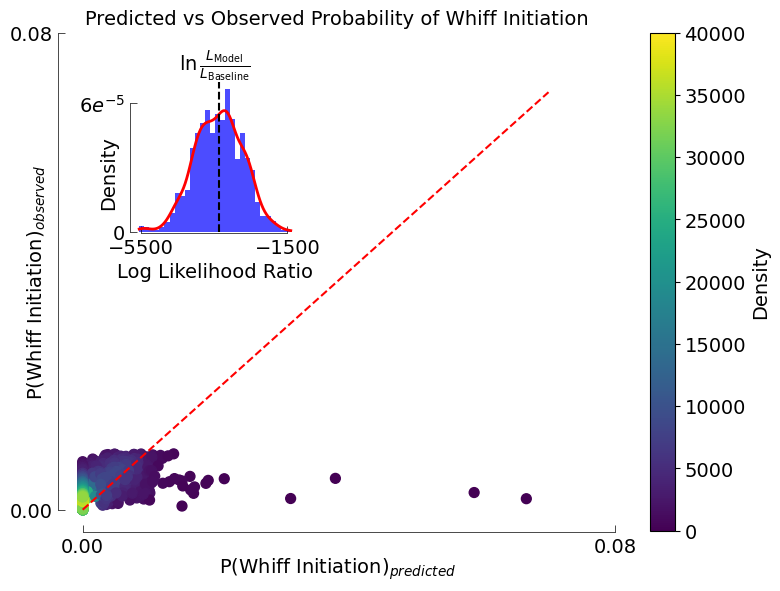

In [163]:

# Define your observed and predicted probabilities
observed_probs = fitted_p_heatmap.flatten()  # Observed probability from actual data
predicted_probs = predicted_prob_heatmap.flatten()  # Predicted probability from model

# Filter out bins with zero total observations to avoid issues with log(0)
valid_bins = heatmap_total.flatten() > 0
observed_probs = observed_probs[valid_bins]
predicted_probs = predicted_probs[valid_bins]
observed_whiff_counts = heatmap_whiff.flatten()[valid_bins]  # Number of observed whiffs per bin
total_counts = heatmap_total.flatten()[valid_bins]  # Total samples per bin

# Step 1: Define the log likelihood function
def calculate_log_likelihood(observed_counts, total_counts, predicted_probs):
    epsilon = 1e-10  # Small constant to avoid log(0)
    predicted_probs = np.clip(predicted_probs, epsilon, 1 - epsilon)
    ll = observed_counts * np.log(predicted_probs) + (total_counts - observed_counts) * np.log(1 - predicted_probs)
    return np.sum(ll)

# Step 2: Baseline Model (e.g., uniform random probability)
# Define a baseline probability (e.g., 0.5, or the mean of the observed probabilities)
baseline_prob = np.mean(observed_probs)
baseline_probs = np.full_like(predicted_probs, baseline_prob)

# Step 3: Bootstrapping for log likelihood ratio
def bootstrap_log_likelihood(observed_counts, total_counts, predicted_probs, baseline_probs, n_bootstraps=1000):
    ll_ratios = []
    for _ in range(n_bootstraps):
        # Resample observed counts with replacement
        resampled_indices = np.random.choice(len(observed_counts), size=len(observed_counts), replace=True)
        resampled_counts = observed_counts[resampled_indices]
        resampled_totals = total_counts[resampled_indices]
        
        # Calculate log likelihood for model predictions and baseline
        ll_pred = calculate_log_likelihood(resampled_counts, resampled_totals, predicted_probs[resampled_indices])
        ll_baseline = calculate_log_likelihood(resampled_counts, resampled_totals, baseline_probs[resampled_indices])
        
        # Log likelihood ratio
        ll_ratio = ll_pred - ll_baseline
        ll_ratios.append(ll_ratio)
    
    return np.array(ll_ratios)

# Run bootstrapping
n_bootstraps = 1000
ll_ratios = bootstrap_log_likelihood(observed_whiff_counts, total_counts, predicted_probs, baseline_probs, n_bootstraps)

# # Step 4: Plot Distribution of Log Likelihood Ratios
# plt.figure(figsize=(8, 6))
# plt.hist(ll_ratios, bins=30, color='blue', alpha=0.7)
# plt.axvline(np.mean(ll_ratios), color='red', linestyle='--', label='Mean Log Likelihood Ratio')
# plt.xlabel('Log Likelihood Ratio (Model - Baseline)')
# plt.ylabel('Frequency')
# plt.title('Distribution of Log Likelihood Ratios (Model vs Baseline)')
# plt.legend()
# plt.show()

# Step 1: Create the main figure and axis
f, ax = plt.subplots(figsize=(8, 6))

# Main density scatter plot (as in your previous example)
xy = np.vstack([predicted_probs, observed_probs])
kde = gaussian_kde(xy)(xy)
scatter = ax.scatter(predicted_probs, observed_probs, c=kde, s=50, cmap='viridis',vmin=0,vmax=40000)
ax.plot([0, 0.07], [0, 0.07], 'r--')  # 45-degree line for perfect prediction
cbar = f.colorbar(scatter, ax=ax, label='Density')
ax.set_xlabel('P(Whiff Initiation)$_{predicted}$')
ax.set_ylabel('P(Whiff Initiation)$_{observed}$')
ax.set_title('Predicted vs Observed Probability of Whiff Initiation')

mpl_functions.adjust_spines(ax,['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,0.08],
                        yticks=[0,0.08],
                        linewidth=0.5)

ax.yaxis.set_label_coords(-0.02, 0.5)
ax.xaxis.set_label_coords(0.5, -0.05)

# Define the position in axis coordinates (e.g., x=0.6, y=0.6 with width and height in axis-relative terms)
bbox = mtransforms.Bbox.from_bounds(-0.57, -0.1, 1, 1)  # (x0, y0, width, height)

# Use transform=ax.transAxes to place it relative to the main axis `ax`
ax_inset = inset_axes(ax, width="30%", height="30%", bbox_to_anchor=bbox, 
                      bbox_transform=ax.transAxes, borderpad=0)

# Plot the histogram of log likelihood ratios on the inset
ax_inset.hist(ll_ratios, bins=30, color='blue', alpha=0.7, density=True)  # `density=True` normalizes the histogram

# Calculate the KDE for log likelihood ratios
kde_ll = gaussian_kde(ll_ratios)

# Generate values for the x-axis and evaluate the KDE
x_vals = np.linspace(min(ll_ratios), max(ll_ratios), 100)
kde_vals = kde_ll(x_vals)

# Plot the KDE line on top of the histogram
ax_inset.plot(x_vals, kde_vals, color='red', linewidth=2)
ax_inset.axvline(np.mean(ll_ratios), color='black', linestyle='--')
ax_inset.set_title(r'$\ln \frac{L_{\text{Model}}}{L_{\text{Baseline}}}$')
ax_inset.set_xlabel('Log Likelihood Ratio')
ax_inset.set_ylabel('Density')

mpl_functions.adjust_spines(ax_inset,['left','bottom'],
                        spine_locations={'left': 1, 'bottom': 1}, 
                        smart_bounds=True,
                        xticks=[-5500,-1500],
                        yticks=[0,0.0006],
                        linewidth=0.5)

ax_inset.yaxis.set_label_coords(-0.08, 0.4)
ax_inset.set_yticklabels([r'$0$',r'$6e^{-5}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()

Wasserstein Distance

In [ ]:
# Calculate Wasserstein distance for each grid cell
wasserstein_results = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        # Select true and predicted odor data for the current grid cell
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor']
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor']
        
        if not true_data.empty and not predicted_data.empty:
            # Wasserstein Distance
            wasserstein_dist = wasserstein_distance(true_data, predicted_data)
            wasserstein_results.append((i, j, wasserstein_dist))

# Convert results to DataFrame
wasserstein_df = pd.DataFrame(wasserstein_results, columns=['Grid X', 'Grid Y', 'Wasserstein Distance'])


wasserstein_matrix = np.zeros((n_bins_y, n_bins_x))
for _, row in wasserstein_df.iterrows():
    wasserstein_matrix[int(row['Grid Y']), int(row['Grid X'])] = row['Wasserstein Distance']

# Plot Wasserstein distances using f, ax = plt.subplots()
f, ax = plt.subplots(figsize=(8, 5))
var = ax.imshow(wasserstein_matrix, cmap='Blues', origin='lower', aspect='auto', vmin=0, vmax=0.4)

# Add color bar with increased height
# cbar = f.colorbar(cax, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='Wasserstein Distance')

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('Wasserstein Distance')

# Set title and labels
ax.set_title('Distribution similarity of the observed vs prediction')
# ax.set_xlabel('Distance along Streakline, m')
# ax.set_ylabel('Nearest from streakline, m' )
ax.set_ylabel('$W_{Distance}$')

# Annotate each cell with the Wasserstein distance value
for i in range(n_bins_y):
    for j in range(n_bins_x):
        ax.text(j, i, f'{wasserstein_matrix[i, j]:.3f}', ha='center', va='center', color='white')
mpl_functions.set_fontsize(f, 14)
f.tight_layout()



In [ ]:
# Combined plot for true and predicted odor concentrations

fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(10, 8))
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_true = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor']
        grid_pred = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_true.empty and not grid_pred.empty:
            sns.histplot(grid_true, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5, label='Observed')
            sns.histplot(grid_pred, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5, label='Predicted')
            ax.set_xlim([specific_x_min, specific_x_max])
            # ax.set_ylim(0,15000)
            ax.legend()
        else:
            ax.axis('off')

fig.suptitle('Overlayed True and Predicted Odor Concentration Histograms', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
from scipy.stats import ks_2samp, anderson_ksamp, chisquare
from scipy.spatial.distance import jensenshannon

# # Set up binning parameters
# n_bins_x = 3
# n_bins_y = 3
# n_bootstraps = 100  # Number of bootstrap samples

# # Create bin edges
# x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
# y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

# # Apply binning to the DataFrame
# new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
# new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

# Function to calculate Bhattacharyya distance
def bhattacharyya_distance(observed_data, predicted_data):
    observed_mean, observed_std = np.mean(observed_data), np.std(observed_data)
    predicted_mean, predicted_std = np.mean(predicted_data), np.std(predicted_data)
    return np.log(0.5 * (observed_std / predicted_std + predicted_std / observed_std)) + \
           0.25 * ((observed_mean - predicted_mean) ** 2) / (observed_std ** 2 + predicted_std ** 2)

# Prepare results list
metrics_results = []

# Loop through each grid cell and apply statistical tests
for i in range(n_bins_x):
    for j in range(n_bins_y):
        # Extract observed and predicted data for grid cell (i, j)
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].dropna().values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].dropna().values

        if len(true_data) > 0 and len(predicted_data) > 0:
            # KS Test
            ks_stat, ks_p_value = ks_2samp(true_data, predicted_data)
            
            # Anderson-Darling Test
            ad_stat, ad_critical_values, ad_p_value = anderson_ksamp([true_data, predicted_data])
            
            # Jensen-Shannon Divergence
            jsd = jensenshannon(true_data, predicted_data)
            
            # Chi-Square Test (requires histogram counts)
            bin_edges = np.histogram_bin_edges(np.concatenate((true_data, predicted_data)), bins=20)
            observed_counts, _ = np.histogram(true_data, bins=bin_edges)
            predicted_counts, _ = np.histogram(predicted_data, bins=bin_edges)
            chi_stat, chi_p_value = chisquare(observed_counts, f_exp=predicted_counts)

            # Bhattacharyya Distance
            bd = bhattacharyya_distance(true_data, predicted_data)

            # Store results
            metrics_results.append({
                'Grid X': i,
                'Grid Y': j,
                'KS Statistic': ks_stat,
                'KS P-value': ks_p_value,
                'AD Statistic': ad_stat,
                'AD P-value': ad_p_value,
                'Jensen-Shannon Divergence': jsd,
                'Chi-Square Statistic': chi_stat,
                'Chi-Square P-value': chi_p_value,
                'Bhattacharyya Distance': bd
            })

# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Display the DataFrame in a nicely formatted table
print(metrics_df.to_string(index=False))


In [ ]:
# Parameters
n_bins_x = 3
n_bins_y = 3

# Calculate Jensen-Shannon Divergence for each grid cell
jsd_results = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        # Select true and predicted odor data for the current grid cell
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].dropna()
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].dropna()
        
        if not true_data.empty and not predicted_data.empty:
            # Jensen-Shannon Divergence
            jsd = jensenshannon(true_data, predicted_data)
            jsd_results.append((i, j, jsd))

# Convert results to DataFrame
jsd_df = pd.DataFrame(jsd_results, columns=['Grid X', 'Grid Y', 'Jensen-Shannon Divergence'])

# Create a matrix to hold the JSD values for plotting
jsd_matrix = np.zeros((n_bins_y, n_bins_x))
for _, row in jsd_df.iterrows():
    jsd_matrix[int(row['Grid Y']), int(row['Grid X'])] = row['Jensen-Shannon Divergence']

# Plot JSD in grid layout
f, ax = plt.subplots(figsize=(8, 5))
var = ax.imshow(jsd_matrix, cmap='Blues', origin='lower', aspect='auto', vmin=0, vmax=0.5)

# Add color bar with custom placement
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var, cax=cax1, orientation='vertical')
cbar1.set_label('Jensen-Shannon Divergence')

# Set title and labels
ax.set_title('Jensen-Shannon Divergence of Observed vs Predicted Distributions')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')

# Annotate each cell with the JSD value
for i in range(n_bins_y):
    for j in range(n_bins_x):
        ax.text(j, i, f'{jsd_matrix[i, j]:.3f}', ha='center', va='center', color='black')


In [ ]:

# Define the function to calculate bootstrap Wasserstein distances
def bootstrap_wasserstein(true_data, predicted_data, n_bootstraps):
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        bootstrap_true = np.random.choice(true_data, size=len(true_data), replace=True)
        bootstrap_predicted = np.random.choice(predicted_data, size=len(predicted_data), replace=True)
        bootstrap_wasserstein = wasserstein_distance(bootstrap_true, bootstrap_predicted)
        bootstrap_distances.append(bootstrap_wasserstein)
    return bootstrap_distances

# Define the function to process each grid
def process_grid(args):
    i, j, true_data, predicted_data, n_bootstraps = args
    if len(true_data) > 0 and len(predicted_data) > 0:
        observed_wasserstein = wasserstein_distance(true_data, predicted_data)
        bootstrap_distances = bootstrap_wasserstein(true_data, predicted_data, n_bootstraps)
        bootstrap_distances = np.array(bootstrap_distances)
        p_value = round(np.mean(bootstrap_distances >= observed_wasserstein), 4)
        return (i, j, observed_wasserstein, p_value, bootstrap_distances)
    return (i, j, None, None, None)

# Assume `new_test_df1` and `new_test_df2` have columns 'x_bin', 'y_bin', 'odor', and 'predicted_odor'
args_list = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].values
        args_list.append((i, j, true_data, predicted_data, n_bootstraps))

# Use multiprocessing to parallelize the process
with mp.Pool(processes=mp.cpu_count() - 4) as pool:
    results = pool.map(process_grid, args_list)

# Collect results
bootstrap_results = []
all_bootstrap_distances = []
for result in results:
    i, j, observed_wasserstein, p_value, bootstrap_distances = result
    if observed_wasserstein is not None:
        bootstrap_results.append((i, j, observed_wasserstein, p_value))
        all_bootstrap_distances.append((i, j, bootstrap_distances))

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results, columns=['Grid X', 'Grid Y', 'Observed Wasserstein', 'P-value']).round({'P-value': 4})

# Plot each grid separately
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(12, 8))
fig.suptitle('Bootstrap Distribution of Wasserstein Distances per Grid', fontsize=16)

for i in range(n_bins_x):
    for j in range(n_bins_y):
        ax = axes[n_bins_y - 1 - j, i]  # Adjust to have (0,0) at the top-left
        
        # Find bootstrap distances for current grid cell
        try:
            bootstrap_distances = next(item[2] for item in all_bootstrap_distances if item[0] == i and item[1] == j)
            observed_wasserstein = bootstrap_df[(bootstrap_df['Grid X'] == i) & (bootstrap_df['Grid Y'] == j)]['Observed Wasserstein'].values[0]
            
            # Plot histogram of bootstrap distances
            sns.histplot(bootstrap_distances, bins=20, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            
            # Plot observed Wasserstein distance as a vertical line
            ax.axvline(observed_wasserstein, color='red', linestyle='--', linewidth=2, label='Grid $W_d$')
            if (i, j) == (2, 0):
                ax.legend(loc='upper right')
            
            if i == 0:
                ax.set_ylabel('Frequency')
            if j == 0:
                ax.set_xlabel('$W_{Distance}')
        
        except StopIteration:
            # If no bootstrap distances found, skip plotting for this grid cell
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
n_bootstraps=1000
def bootstrap_wasserstein(true_data, predicted_data, n_bootstraps):
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        # Resample with replacement from true and predicted data
        bootstrap_true = np.random.choice(true_data, size=len(true_data), replace=True)
        bootstrap_predicted = np.random.choice(predicted_data, size=len(predicted_data), replace=True)
        bootstrap_wasserstein = wasserstein_distance(bootstrap_true, bootstrap_predicted)
        bootstrap_distances.append(bootstrap_wasserstein)
    return bootstrap_distances

# Define the function to process each grid
def process_grid(args):
    i, j, true_data, predicted_data, n_bootstraps = args
    if len(true_data) > 0 and len(predicted_data) > 0:
        # Calculate observed Wasserstein distance
        observed_wasserstein = wasserstein_distance(true_data, predicted_data)
        # Generate bootstrap samples and calculate Wasserstein distances
        bootstrap_distances = bootstrap_wasserstein(true_data, predicted_data, n_bootstraps)
        bootstrap_distances = np.array(bootstrap_distances)
        p_value = round(np.mean(bootstrap_distances >= observed_wasserstein), 4)
        return (i, j, observed_wasserstein, p_value, bootstrap_distances)
    return (i, j, None, None, None)

# Prepare arguments for multiprocessing
args_list = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].values
        args_list.append((i, j, true_data, predicted_data, n_bootstraps))

# Use multiprocessing to parallelize the bootstrapping process
with mp.Pool(processes=mp.cpu_count() - 4) as pool:
    results = pool.map(process_grid, args_list)

# Collect results
bootstrap_results = []
all_bootstrap_distances = []
for result in results:
    i, j, observed_wasserstein, p_value, bootstrap_distances = result
    if observed_wasserstein is not None:
        bootstrap_results.append((i, j, observed_wasserstein, p_value))
        all_bootstrap_distances.append((i, j, bootstrap_distances))

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results, columns=['Grid X', 'Grid Y', 'Observed Wasserstein', 'P-value']).round({'P-value': 4})

# Plot each grid separately as subplots in a 3x3 layout
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(12, 8))
fig.suptitle('Bootstrap Distribution of Wasserstein Distances per Grid', fontsize=16)

for i in range(n_bins_x):
    for j in range(n_bins_y):
        ax = axes[n_bins_y - 1 - j, i]  # Adjust to have (0,0) at the top-left
        try:
            # Get bootstrap distances for the current grid cell
            bootstrap_distances = next(item[2] for item in all_bootstrap_distances if item[0] == i and item[1] == j)
            observed_wasserstein = bootstrap_df[(bootstrap_df['Grid X'] == i) & (bootstrap_df['Grid Y'] == j)]['Observed Wasserstein'].values[0]
            
            # Plot histogram of bootstrap distances
            sns.histplot(bootstrap_distances, bins=20, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            
            # Plot observed Wasserstein distance as a vertical line
            ax.axvline(observed_wasserstein, color='red', linestyle='--', linewidth=2, label='Observed $W_d$')
            if (i, j) == (2, 0):
                ax.legend(loc='upper right')

            if i == 0:
                ax.set_ylabel('Frequency')
            if j == 0:
                ax.set_xlabel('Wasserstein Distance')
        
        except StopIteration:
            # If no data found for the current grid cell, display "No Data" in the subplot
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
n_bootstraps=1000
# Define the function to calculate bootstrap Wasserstein distances with combined resampling
def bootstrap_wasserstein_combined(true_data, predicted_data, n_bootstraps):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        bootstrap_true = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_predicted = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_wasserstein = wasserstein_distance(bootstrap_true, bootstrap_predicted)
        bootstrap_distances.append(bootstrap_wasserstein)
    return bootstrap_distances

# Define the function to process each grid
def process_grid(args):
    i, j, true_data, predicted_data, n_bootstraps = args
    if len(true_data) > 0 and len(predicted_data) > 0:
        observed_wasserstein = wasserstein_distance(true_data, predicted_data)
        bootstrap_distances = bootstrap_wasserstein_combined(true_data, predicted_data, n_bootstraps)
        p_value = round(np.mean(np.array(bootstrap_distances) >= observed_wasserstein), 4)
        return (i, j, observed_wasserstein, p_value, bootstrap_distances)
    return (i, j, None, None, None)

# Prepare arguments for multiprocessing
args_list = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].values
        args_list.append((i, j, true_data, predicted_data, n_bootstraps))

# Use multiprocessing to parallelize the bootstrapping process
with mp.Pool(processes=mp.cpu_count() - 4) as pool:
    results = pool.map(process_grid, args_list)

# Collect results
bootstrap_results = []
all_bootstrap_distances = []
for result in results:
    i, j, observed_wasserstein, p_value, bootstrap_distances = result
    if observed_wasserstein is not None:
        bootstrap_results.append((i, j, observed_wasserstein, p_value))
        all_bootstrap_distances.append((i, j, bootstrap_distances))

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results, columns=['Grid X', 'Grid Y', 'Observed Wasserstein', 'P-value']).round({'P-value': 4})

# Plot each grid separately as subplots in a 3x3 layout
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(10, 8))
fig.suptitle('Bootstrap Distribution of Wasserstein Distances per Grid', fontsize=16)

for i in range(n_bins_x):
    for j in range(n_bins_y):
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        try:
            # Get the bootstrap distances and observed Wasserstein for the current grid cell
            bootstrap_distances = next(item[2] for item in all_bootstrap_distances if item[0] == i and item[1] == j)
            observed_wasserstein = bootstrap_df[(bootstrap_df['Grid X'] == i) & (bootstrap_df['Grid Y'] == j)]['Observed Wasserstein'].values[0]
            
            # Plot histogram of bootstrap distances
            sns.histplot(bootstrap_distances, bins=20, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            
            # Plot observed Wasserstein distance as a vertical line
            ax.axvline(observed_wasserstein, color='red', linestyle='--', linewidth=2, label='Observed Wd')
            if (i, j) == (2, 0):
                ax.legend(loc='upper right')

            if i == 0:
                ax.set_ylabel('Frequency')
            ax.set_xlabel('Wasserstein Distance')

        except StopIteration:
            # If no data found for the current grid cell, display "No Data" in the subplot
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])



In [ ]:

# Function to calculate JSD with histograms
def calculate_jsd(true_data, predicted_data, n_bins):
    min_val = min(true_data.min(), predicted_data.min())
    max_val = max(true_data.max(), predicted_data.max())
    
    true_hist, _ = np.histogram(true_data, bins=n_bins, range=(min_val, max_val), density=True)
    pred_hist, _ = np.histogram(predicted_data, bins=n_bins, range=(min_val, max_val), density=True)
    
    return jensenshannon(true_hist, pred_hist)

# Bootstrap function for JSD with histograms
def bootstrap_jsd_combined(true_data, predicted_data, n_bootstraps, n_bins):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        bootstrap_true = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_pred = np.random.choice(combined_data, size=len(combined_data), replace=True)
        jsd = calculate_jsd(bootstrap_true, bootstrap_pred, n_bins)
        bootstrap_distances.append(jsd)
    return bootstrap_distances

# Process each grid cell for JSD with bootstrapping
def process_grid_jsd(args):
    i, j, true_data, predicted_data, n_bootstraps, n_bins_hist = args
    if len(true_data) > 0 and len(predicted_data) > 0:
        observed_jsd = calculate_jsd(true_data, predicted_data, n_bins_hist)
        bootstrap_distances = bootstrap_jsd_combined(true_data, predicted_data, n_bootstraps, n_bins_hist)
        p_value = round(np.mean(np.array(bootstrap_distances) >= observed_jsd), 4)
        return (i, j, observed_jsd, p_value, bootstrap_distances)
    return (i, j, None, None, None)

# Prepare arguments for multiprocessing
args_list = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].values
        args_list.append((i, j, true_data, predicted_data, n_bootstraps, n_bins_hist))

# Use multiprocessing to parallelize the bootstrapping process
with mp.Pool(processes=mp.cpu_count() - 4) as pool:
    results = pool.map(process_grid_jsd, args_list)

# Collect results
bootstrap_results_jsd = []
all_bootstrap_distances_jsd = []
for result in results:
    i, j, observed_jsd, p_value, bootstrap_distances = result
    if observed_jsd is not None:
        bootstrap_results_jsd.append((i, j, observed_jsd, p_value))
        all_bootstrap_distances_jsd.append((i, j, bootstrap_distances))

# Convert results to DataFrame
bootstrap_jsd_df = pd.DataFrame(bootstrap_results_jsd, columns=['Grid X', 'Grid Y', 'Observed JSD', 'P-value']).round({'P-value': 4})

# Plot each grid separately as subplots in a 3x3 layout
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(10, 8))
fig.suptitle('Bootstrap Distribution of Jensen-Shannon Divergences per Grid', fontsize=16)

for i in range(n_bins_x):
    for j in range(n_bins_y):
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        try:
            bootstrap_distances = next(item[2] for item in all_bootstrap_distances_jsd if item[0] == i and item[1] == j)
            observed_jsd = bootstrap_jsd_df[(bootstrap_jsd_df['Grid X'] == i) & (bootstrap_jsd_df['Grid Y'] == j)]['Observed JSD'].values[0]
            
            # Plot histogram of bootstrap JSD values
            sns.histplot(bootstrap_distances, bins=20, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            
            # Plot observed JSD as a vertical line
            ax.axvline(observed_jsd, color='red', linestyle='--', linewidth=2, label='Observed JSD')
            if (i, j) == (0, 0):
                ax.legend(loc='upper right')

            if i == 0:
                ax.set_ylabel('Frequency')
            ax.set_xlabel('Jensen-Shannon Divergence')
        
        except StopIteration:
            # If no data found for the current grid cell, display "No Data" in the subplot
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Function to calculate Cohen's d
def cohen_d(true_data, predicted_data):
    mean1, mean2 = np.mean(true_data), np.mean(predicted_data)
    std1, std2 = np.std(true_data, ddof=1), np.std(predicted_data, ddof=1)
    pooled_std = np.sqrt(((len(true_data) - 1) * std1**2 + (len(predicted_data) - 1) * std2**2) / (len(true_data) + len(predicted_data) - 2))
    return (mean1 - mean2) / pooled_std

# Set up grid parameters (assuming this is part of your larger grid analysis)
n_bins_x = 3
n_bins_y = 3

# Collect Cohen's d results
cohen_d_results = []

for i in range(n_bins_x):
    for j in range(n_bins_y):
        # Select true and predicted data for the current grid cell
        true_data = new_test_df1[(new_test_df1['x_bin'] == i) & (new_test_df1['y_bin'] == j)]['odor'].values
        predicted_data = new_test_df2[(new_test_df2['x_bin'] == i) & (new_test_df2['y_bin'] == j)]['predicted_odor'].values
        
        if len(true_data) > 1 and len(predicted_data) > 1:  # Ensure sufficient data points for calculation
            d = cohen_d(true_data, predicted_data)
            cohen_d_results.append((i, j, d))
        else:
            cohen_d_results.append((i, j, None))  # Not enough data to calculate Cohen's d

# Convert results to DataFrame
cohen_d_df = pd.DataFrame(cohen_d_results, columns=['Grid X', 'Grid Y', 'Cohen\'s d'])

# Display the Cohen's d results
print(cohen_d_df)


In [ ]:

def bootstrap_wasserstein_combined(true_data, predicted_data, n_bootstraps):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        # Resample with replacement from combined data
        bootstrap_true = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_predicted = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_wasserstein = wasserstein_distance(bootstrap_true, bootstrap_predicted)
        bootstrap_distances.append(bootstrap_wasserstein)
    return bootstrap_distances

# Dummy Data Generation
def generate_dummy_data(same_distribution=True, n_samples=1000):
    if same_distribution:
        # Generate two datasets from the same normal distribution
        data1 = np.random.normal(loc=0, scale=1, size=n_samples)
        data2 = np.random.normal(loc=0, scale=1, size=n_samples)
    else:
        # Generate two datasets from different normal distributions
        data1 = np.random.normal(loc=0, scale=1, size=n_samples)
        data2 = np.random.normal(loc=1, scale=1, size=n_samples)
    return data1, data2

# Testing function to compare two distributions and plot the results
def test_combined_approach(data1, data2, n_bootstraps=1000):
    observed_wasserstein = wasserstein_distance(data1, data2)
    bootstrap_distances = bootstrap_wasserstein_combined(data1, data2, n_bootstraps)

    # Calculate p-value
    p_value = round(np.mean(bootstrap_distances >= observed_wasserstein), 4)

    # Plot the bootstrap distribution and the observed Wasserstein distance
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrap_distances, bins=20, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
    plt.axvline(observed_wasserstein, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value})')
    plt.xlabel('Wasserstein Distance')
    plt.ylabel('Frequency')
    plt.title('Bootstrap Distribution of Wasserstein Distances')
    plt.legend()
    plt.show()

    print(f"Observed Wasserstein Distance: {observed_wasserstein}")
    print(f"P-value: {p_value}")

# Test case 1: Same distribution (expected high p-value)
print("Testing with same distribution (expected high p-value):")
data1, data2 = generate_dummy_data(same_distribution=True)
test_combined_approach(data1, data2)

# Test case 2: Different distributions (expected low p-value)
print("\nTesting with different distributions (expected low p-value):")
data1, data2 = generate_dummy_data(same_distribution=False)
test_combined_approach(data1, data2)


In [ ]:

from scipy.spatial.distance import jensenshannon

# Modified bootstrap function for Jensen-Shannon Divergence
def bootstrap_jsd_combined(true_data, predicted_data, n_bootstraps, n_bins=50):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        # Resample with replacement from combined data
        bootstrap_true = np.random.choice(combined_data, size=len(combined_data), replace=True)
        bootstrap_predicted = np.random.choice(combined_data, size=len(combined_data), replace=True)
        
        # Calculate histograms and normalize them to obtain probability distributions
        hist_true, _ = np.histogram(bootstrap_true, bins=n_bins, range=(combined_data.min(), combined_data.max()), density=True)
        hist_pred, _ = np.histogram(bootstrap_predicted, bins=n_bins, range=(combined_data.min(), combined_data.max()), density=True)
        
        # Calculate Jensen-Shannon Divergence
        jsd = jensenshannon(hist_true, hist_pred)
        bootstrap_distances.append(jsd)
    return bootstrap_distances

# Dummy Data Generation
def generate_dummy_data(same_distribution=True, n_samples=10000):
    if same_distribution:
        # Generate two datasets from the same normal distribution
        data1 = np.random.normal(loc=0, scale=1, size=n_samples)
        data2 = np.random.normal(loc=0, scale=1, size=n_samples)
    else:
        # Generate two datasets from different normal distributions
        data1 = np.random.normal(loc=0, scale=1, size=n_samples)
        data2 = np.random.normal(loc=1, scale=1, size=n_samples)
    return data1, data2

# Testing function to compare two distributions and plot the results using JSD
def test_combined_jsd_approach(data1, data2, n_bootstraps=1000, n_bins=50):
    # Calculate histograms for observed data and normalize them for probability distributions
    hist_data1, _ = np.histogram(data1, bins=n_bins, range=(min(data1.min(), data2.min()), max(data1.max(), data2.max())), density=True)
    hist_data2, _ = np.histogram(data2, bins=n_bins, range=(min(data1.min(), data2.min()), max(data1.max(), data2.max())), density=True)
    
    # Calculate observed JSD
    observed_jsd = jensenshannon(hist_data1, hist_data2)
    
    # Perform bootstrapping
    bootstrap_distances = bootstrap_jsd_combined(data1, data2, n_bootstraps, n_bins)

    # Calculate p-value
    p_value = round(np.mean(bootstrap_distances >= observed_jsd), 4)

    # Plot the bootstrap distribution and the observed JSD
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrap_distances, bins=20, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
    plt.axvline(observed_jsd, color='red', linestyle='--', linewidth=2, label=f'Observed JSD (p-value={p_value})')
    plt.xlabel('Jensen-Shannon Divergence')
    plt.ylabel('Frequency')
    plt.title('Bootstrap Distribution of Jensen-Shannon Divergence')
    plt.legend()
    plt.show()

    print(f"Observed Jensen-Shannon Divergence: {observed_jsd}")
    print(f"P-value: {p_value}")

# Test case 1: Same distribution (expected high p-value)
print("Testing with same distribution (expected high p-value):")
data1, data2 = generate_dummy_data(same_distribution=True)
test_combined_jsd_approach(data1, data2)

# Test case 2: Different distributions (expected low p-value)
print("\nTesting with different distributions (expected low p-value):")
data1, data2 = generate_dummy_data(same_distribution=False)
test_combined_jsd_approach(data1, data2)


In [1]:
#### whiff probability map with more considerations

# Helper function: Smooth probabilities from the heatmap
def smooth_heatmap_probability(hmap, x_bin, y_bin):
    x_min = max(0, x_bin - 1)
    x_max = min(hmap.shape[0], x_bin + 2)
    y_min = max(0, y_bin - 1)
    y_max = min(hmap.shape[1], y_bin + 2)
    
    return np.mean(hmap[x_min:x_max, y_min:y_max])

def decay_factor(time_since_last_whiff, min_gap=0.5, decay_rate=0.2):
    if time_since_last_whiff < min_gap:
        return 0.1  # Assign a small baseline decay factor
    return np.exp(-decay_rate * (time_since_last_whiff - min_gap))


# Helper function: Neighbor bin influence
def neighbor_influence(hmap, x_bin, y_bin, weight=0.5):
    x_min = max(0, x_bin - 1)
    x_max = min(hmap.shape[0], x_bin + 2)
    y_min = max(0, y_bin - 1)
    y_max = min(hmap.shape[1], y_bin + 2)
    
    # Combine current bin and neighbors
    neighbors = hmap[x_min:x_max, y_min:y_max].flatten()
    current_prob = hmap[x_bin, y_bin]
    return (1 - weight) * current_prob + weight * np.mean(neighbors)

# Helper function: Streak penalty
def streak_penalty(whiff_streak, max_streak=3):
    if whiff_streak >= max_streak:
        return 0.7  # Reduce probability by 50% if streak is too long
    return 1.0


def predict_whiff_from_probability(x, y, hmap, xedges, yedges, 
                                   time_since_last_whiff, whiff_streak):
    # Locate the bin
    x_bin = np.digitize(x, xedges) - 1
    y_bin = np.digitize(y, yedges) - 1

    # Check boundaries
    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0

    # Base probabilities
    base_prob = hmap[x_bin, y_bin]
    smoothed_prob = smooth_heatmap_probability(hmap, x_bin, y_bin)
    neighbor_prob = neighbor_influence(hmap, x_bin, y_bin, weight=0.5)

    # Adjustments
    decay = decay_factor(time_since_last_whiff, min_gap=0.5, decay_rate=0.1)  # Assign baseline decay
    streak_adjustment = streak_penalty(whiff_streak, max_streak=5)  # Less restrictive streak penalty

    # Combine probabilities
    adjusted_prob = (
        0.8 * base_prob +      # Base heatmap probability (higher weight)
        0.5 * smoothed_prob +  # Smoothed probability
        0.1 * neighbor_prob    # Neighbor influence (lower weight)
    ) * decay * streak_adjustment  # Apply temporal and streak adjustments

    # Clip adjusted_prob to a meaningful lower bound
    adjusted_prob = max(adjusted_prob, 0.005)  # Minimum probability of 0.01

    # Prediction
    whiff_predicted = np.random.rand() < adjusted_prob
    return whiff_predicted, adjusted_prob
